# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Compute Link Stats

Let's compute linkage statistics from our data!

We are first going to define our gender codes.  We'll start with the resolved codes:

In [2]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [3]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

Now we can load gender data:

In [4]:
viaf_genders = pd.read_parquet('book-links/cluster-genders.parquet')
viaf_genders = viaf_genders.set_index('cluster')['gender']
viaf_genders = viaf_genders.astype('category')
viaf_genders.cat.add_categories('no-book', inplace=True)
viaf_genders.cat.reorder_categories(link_codes + unlink_codes, inplace=True)
viaf_genders.describe()

count           27456006
unique                 6
top       no-book-author
freq            18556078
Name: gender, dtype: object

In [7]:
isbn_clusters = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
isbn_clusters = isbn_clusters.set_index('isbn_id')['cluster']
isbn_clusters

isbn_id
22428010    100109686
9352692     100109686
9352685     100109686
9352691     100109686
20415466    100109686
              ...    
24503756    421833421
24503757    416168734
24503758    418243823
24503760    924503760
24503761    419058241
Name: cluster, Length: 24503761, dtype: int32

Define a variable to store all of these:

In [8]:
source_stats = {}

### LOC book corpus

In [9]:
loc_isbns = pd.read_parquet('loc-mds/book-isbn-ids.parquet')
loc_clusters = loc_isbns.join(isbn_clusters, on='isbn_id')
loc_clusters

,rec_id,isbn_id,cluster
0,2683918,2089,108136695
1,2495515,4431,100092135
2,3979089,4561,106189620
3,1859812,4608,110730339
4,2339687,4713,109430144
...,...,...,...
7763013,8699114,23501625,308699114
7763014,9344760,23501656,309344760
7763015,9532553,23501668,309532553
7763016,9028271,23502681,309028271


In [10]:
loc_genders = loc_clusters.join(viaf_genders, on='cluster', how='left')
loc_genders

,rec_id,isbn_id,cluster,gender
0,2683918,2089,108136695,male
1,2495515,4431,100092135,female
2,3979089,4561,106189620,female
3,1859812,4608,110730339,male
4,2339687,4713,109430144,female
...,...,...,...,...
7763013,8699114,23501625,308699114,no-book-author
7763014,9344760,23501656,309344760,male
7763015,9532553,23501668,309532553,unknown
7763016,9028271,23502681,309028271,male


In [11]:
loc_stats = loc_genders.groupby('gender')['rec_id'].count()
loc_stats = loc_stats.to_frame('n_books')
loc_stats

,n_books
gender,
female,1085968
male,3348804
ambiguous,124813
unknown,1646571
no-author-rec,384575
no-book-author,1172287
no-book,0


In [12]:
source_stats['LOC-MDS'] = loc_stats

### BookCrossing

We want to process action genders.  Each action frame will have an 'item' column that we use - let's define a helper function:

In [13]:
def action_stats(df):
    joined = df.join(viaf_genders, on='item', how='left')
    joined['gender'].fillna('no-book', inplace=True)
    return joined.groupby('gender')['item'].agg(['nunique', 'count']).rename(columns={
        'nunique': 'n_books',
        'count': 'n_actions'
    })

Do the implicit actions:

In [14]:
bx_actions = pd.read_parquet('bx/bx-cluster-actions.parquet')
bx_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427065 entries, 0 to 427064
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      427065 non-null  uint32
 1   item      427065 non-null  int32 
 2   nactions  427065 non-null  uint32
dtypes: int32(1), uint32(2)
memory usage: 4.9 MB


In [15]:
bx_act_stats = action_stats(bx_actions)
bx_act_stats

,n_books,n_actions
gender,,
female,38080,138487
male,56434,184505
ambiguous,4212,32744
unknown,17001,27574
no-author-rec,6875,8759
no-book-author,28430,34996
no-book,0,0


In [16]:
source_stats['BX-I'] = bx_act_stats

And now we do ratings:

In [17]:
bx_ratings = pd.read_parquet('bx/bx-cluster-ratings.parquet')
bx_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427065 entries, 0 to 427064
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      427065 non-null  uint32 
 1   item      427065 non-null  int32  
 2   rating    427065 non-null  float32
 3   nratings  427065 non-null  uint32 
dtypes: float32(1), int32(1), uint32(2)
memory usage: 6.5 MB


In [18]:
bx_rate_stats = action_stats(bx_ratings)
bx_rate_stats

,n_books,n_actions
gender,,
female,38080,138487
male,56434,184505
ambiguous,4212,32744
unknown,17001,27574
no-author-rec,6875,8759
no-book-author,28430,34996
no-book,0,0


In [19]:
source_stats['BX-E'] = bx_rate_stats

### Amazon data

Let's process the Amazon data:

In [27]:
az_ratings = pd.read_parquet('az2014/az-cluster-ratings.parquet', columns=['user', 'item'])
az_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22457368 entries, 0 to 22457367
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    uint32
 1   item    int32 
dtypes: int32(1), uint32(1)
memory usage: 171.3 MB


In [25]:
az_stats = action_stats(az_ratings)
az_stats

,n_books,n_actions
gender,,
female,217855,4339336
male,491560,6606737
ambiguous,17832,610220
unknown,239621,2093169
no-author-rec,141257,736395
no-book-author,1156610,8071511
no-book,0,0


In [26]:
source_stats['AZ'] = az_stats

### GoodReads

Finally, we will load the GoodReads data.  First the ratings:

In [29]:
gr_ratings = pd.read_parquet('goodreads/gr-cluster-ratings.parquet', columns=['user', 'item'])
gr_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100180351 entries, 0 to 100180350
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    uint32
 1   item    int32 
dtypes: int32(1), uint32(1)
memory usage: 764.3 MB


In [31]:
gr_rate_stats = action_stats(gr_ratings)
gr_rate_stats

,n_books,n_actions
gender,,
female,175690,34586008
male,279432,34900583
ambiguous,11656,9315132
unknown,96483,3973094
no-author-rec,30127,523795
no-book-author,891464,16881739
no-book,0,0


In [33]:
source_stats['GR-E'] = gr_rate_stats
del gr_ratings

And now the actions:

In [30]:
gr_actions = pd.read_parquet('goodreads/gr-cluster-actions.parquet', columns=['user', 'item'])
gr_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220999791 entries, 0 to 220999790
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    uint32
 1   item    int32 
dtypes: int32(1), uint32(1)
memory usage: 1.6 GB


In [35]:
gr_act_stats = action_stats(gr_actions)
gr_act_stats

,n_books,n_actions
gender,,
female,177301,76091597
male,282823,71254945
ambiguous,11763,15123169
unknown,98253,10502922
no-author-rec,30842,1487249
no-book-author,905429,46539909
no-book,0,0


In [36]:
source_stats['GR-I'] = gr_act_stats
del gr_actions

### Integrating Statistics

Time to integrate all of these:

In [37]:
link_stats = pd.concat(source_stats, names=['dataset'])
link_stats

n_books   n_actions
dataset  gender                             
LOC-MDS  female          1085968         NaN
         male            3348804         NaN
         ambiguous        124813         NaN
         unknown         1646571         NaN
         no-author-rec    384575         NaN
         no-book-author  1172287         NaN
         no-book               0         NaN
BX-I     female            38080    138487.0
         male              56434    184505.0
         ambiguous          4212     32744.0
         unknown           17001     27574.0
         no-author-rec      6875      8759.0
         no-book-author    28430     34996.0
         no-book               0         0.0
BX-E     female            38080    138487.0
         male              56434    184505.0
         ambiguous          4212     32744.0
         unknown           17001     27574.0
         no-author-rec      6875      8759.0
         no-book-author    28430     34996.0
         no-book               0         0.0
AZ       female           217855   4339336.0
         male             491560   6606737.0
         ambiguous         17832    610220.0
         unknown          239621   2093169.0
         no-author-rec    141257    736395.0
         no-book-author  1156610   8071511.0
         no-book               0         0.0
GR-RATES female           175690  34586008.0
         male             279432  34900583.0
         ambiguous         11656   9315132.0
         unknown           96483   3973094.0
         no-author-rec     30127    523795.0
         no-book-author   891464  16881739.0
         no-book               0         0.0
GR-E     female           175690  34586008.0
         male             279432  34900583.0
         ambiguous         11656   9315132.0
         unknown           96483   3973094.0
         no-author-rec     30127    523795.0
         no-book-author   891464  16881739.0
         no-book               0         0.0
GR-I     female           177301  76091597.0
         male             282823  71254945.0
         ambiguous         11763  15123169.0
         unknown           98253  10502922.0
         no-author-rec     30842   1487249.0
         no-book-author   905429  46539909.0
         no-book               0         0.0

Now we'll pivot each of our count columns into a table for easier reference.

In [38]:
book_counts = link_stats['n_books'].unstack()
book_counts.sort_index(inplace=True)
book_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,217855,491560,17832,239621,141257,1156610,0
BX-E,38080,56434,4212,17001,6875,28430,0
BX-I,38080,56434,4212,17001,6875,28430,0
GR-E,175690,279432,11656,96483,30127,891464,0
GR-I,177301,282823,11763,98253,30842,905429,0
GR-RATES,175690,279432,11656,96483,30127,891464,0
LOC-MDS,1085968,3348804,124813,1646571,384575,1172287,0


In [39]:
act_counts = link_stats['n_actions'].unstack()
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts.sort_index(inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4339336.0,6606737.0,610220.0,2093169.0,736395.0,8071511.0,0.0
BX-E,138487.0,184505.0,32744.0,27574.0,8759.0,34996.0,0.0
BX-I,138487.0,184505.0,32744.0,27574.0,8759.0,34996.0,0.0
GR-E,34586008.0,34900583.0,9315132.0,3973094.0,523795.0,16881739.0,0.0
GR-I,76091597.0,71254945.0,15123169.0,10502922.0,1487249.0,46539909.0,0.0
GR-RATES,34586008.0,34900583.0,9315132.0,3973094.0,523795.0,16881739.0,0.0


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [40]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [41]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [42]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.096194,0.217050,0.007874,0.105805,0.062372,0.510704,0.0
BX-E,0.252132,0.373656,0.027888,0.112566,0.045520,0.188238,0.0
BX-I,0.252132,0.373656,0.027888,0.112566,0.045520,0.188238,0.0
GR-E,0.118322,0.188188,0.007850,0.064978,0.020290,0.600372,0.0
GR-I,0.117698,0.187746,0.007809,0.065223,0.020474,0.601050,0.0
GR-RATES,0.118322,0.188188,0.007850,0.064978,0.020290,0.600372,0.0
LOC-MDS,0.139890,0.431379,0.016078,0.212104,0.049539,0.151009,0.0


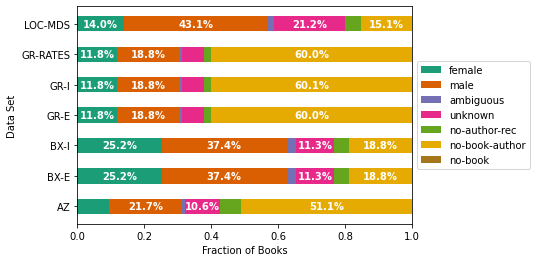

In [43]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [68]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
BX-E,0.250998,0.371970,0.027714,0.112256,0.237062
BX-I,0.240499,0.351097,0.025563,0.124745,0.258097
LOC-MDS,0.139890,0.431379,0.016078,0.212104,0.200549


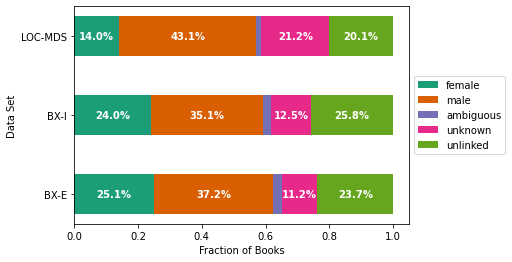

In [69]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

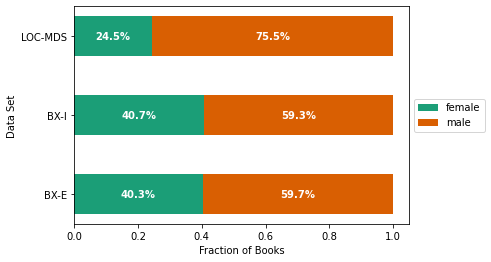

In [70]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [71]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
BX-E,0.321676,0.429631,0.076130,0.064455,0.020488,0.081536,0.006083
BX-I,0.343733,0.411481,0.071411,0.069080,0.020627,0.077879,0.005789


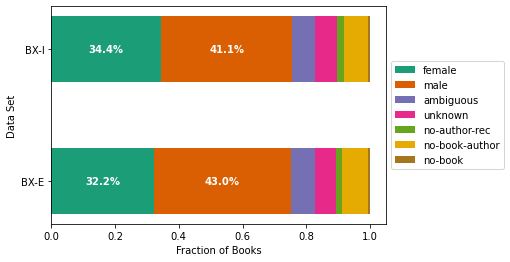

In [72]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [55]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
BX-I,0.343733,0.411481,0.071411,0.069080,0.104295
BX-E,0.321676,0.429631,0.076130,0.064455,0.108107


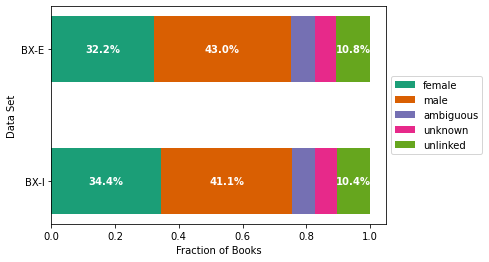

In [56]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

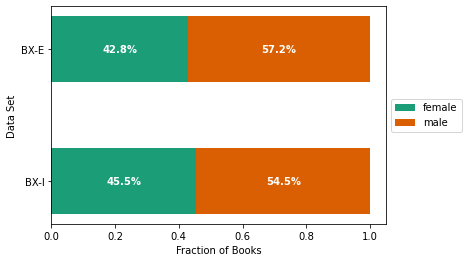

In [57]:
plot_bars(fractionalize(act_counts, ['female', 'male']))